# Project 3: MNIST with SageMaker Spark

### Load SageMaker jars

In [1]:
import sagemaker_pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from sagemaker_pyspark import IAMRole, classpath_jars
from sagemaker_pyspark.algorithms import KMeansSageMakerEstimator

# Load the sagemaker_pyspark classpath. If you used --jars to submit your job
# there is no need to do this in code.
conf = (SparkConf()
        .set("spark.driver.extraClassPath", ":".join(classpath_jars())))
SparkContext(conf=conf)

iam_role = "arn:aws:iam::336405771426:role/service-role/AmazonSageMaker-ExecutionRole-20210321T172844"

region = "us-east-1"

### Initialize Spark Session

In [2]:
classpath = ":".join(sagemaker_pyspark.classpath_jars())
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath).getOrCreate()

In [5]:
spark

### Get MNIST data

In [3]:
training_data = spark.read.format("libsvm").option("numFeatures", "784").load("s3a://sagemaker-sample-data-{}/spark/mnist/train/".format(region))
test_data = spark.read.format("libsvm").option("numFeatures", "784").load("s3a://sagemaker-sample-data-{}/spark/mnist/train/".format(region))

In [6]:
training_data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  5.0|(784,[152,153,154...|
|  0.0|(784,[127,128,129...|
|  4.0|(784,[160,161,162...|
|  1.0|(784,[158,159,160...|
|  9.0|(784,[208,209,210...|
|  2.0|(784,[155,156,157...|
|  1.0|(784,[124,125,126...|
|  3.0|(784,[151,152,153...|
|  1.0|(784,[152,153,154...|
|  4.0|(784,[134,135,161...|
|  3.0|(784,[123,124,125...|
|  5.0|(784,[216,217,218...|
|  3.0|(784,[143,144,145...|
|  6.0|(784,[72,73,74,99...|
|  1.0|(784,[151,152,153...|
|  7.0|(784,[211,212,213...|
|  2.0|(784,[151,152,153...|
|  8.0|(784,[159,160,161...|
|  6.0|(784,[100,101,102...|
|  9.0|(784,[209,210,211...|
+-----+--------------------+
only showing top 20 rows



## K-means 

Using ```KMeansSageMakerEstimator``` to train on our data and KMeans Amazon SageMaker model image to host the model. Since an endpoint must be created, this can take a while to complete.

In [4]:
# K-means estimator
kmeans_estimator = KMeansSageMakerEstimator(
    trainingInstanceType="ml.m4.xlarge", # Instance type to train k-means on
    trainingInstanceCount=1,
    endpointInstanceType="ml.m4.xlarge", # Endpoint for model
    endpointInitialInstanceCount=1,
    sagemakerRole=IAMRole(iam_role))

# Set parameters
kmeans_estimator.setK(10)
kmeans_estimator.setFeatureDim(784)

# Fit on training data
kmeans_model = kmeans_estimator.fit(training_data)

# Run predict / deserialization with transform
transformed_data = kmeans_model.transform(test_data)
transformed_data.show()

+-----+--------------------+-------------------+---------------+
|label|            features|distance_to_cluster|closest_cluster|
+-----+--------------------+-------------------+---------------+
|  5.0|(784,[152,153,154...| 1664.3218994140625|            4.0|
|  0.0|(784,[127,128,129...|  1423.726806640625|            2.0|
|  4.0|(784,[160,161,162...| 1691.2786865234375|            0.0|
|  1.0|(784,[158,159,160...|   1355.93408203125|            1.0|
|  9.0|(784,[208,209,210...| 1417.4210205078125|            5.0|
|  2.0|(784,[155,156,157...| 1652.2637939453125|            6.0|
|  1.0|(784,[124,125,126...| 1443.8995361328125|            1.0|
|  3.0|(784,[151,152,153...| 1601.7098388671875|            4.0|
|  1.0|(784,[152,153,154...|   1176.58935546875|            1.0|
|  4.0|(784,[134,135,161...|  1526.646240234375|            3.0|
|  3.0|(784,[123,124,125...|     1487.634765625|            4.0|
|  5.0|(784,[216,217,218...| 1530.1322021484375|            1.0|
|  3.0|(784,[143,144,145.

### Store Endpoint

In [9]:
# Save endpoint name so that we will not need to create a new training job. SageMaker will be able to reference k-means model data from the previous job.
endpoint = kmeans_model.endpointName
print(endpoint)

endpoint-e8fda6d78b34-2021-03-21T21-59-17-413


### How well did k-means do?




Cluster A:


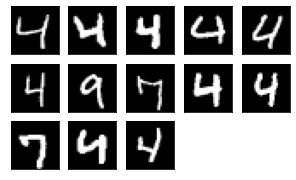




Cluster B:


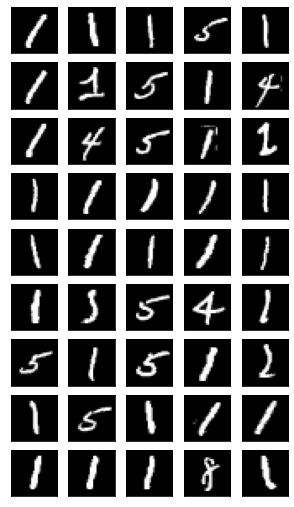




Cluster C:


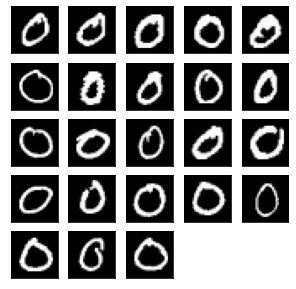




Cluster D:


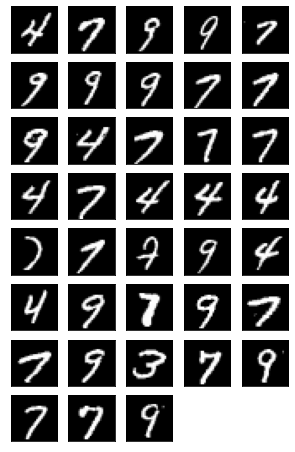




Cluster E:


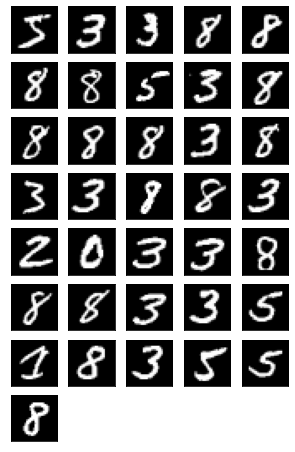




Cluster F:


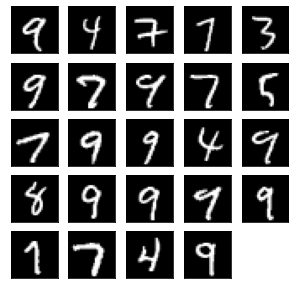




Cluster G:


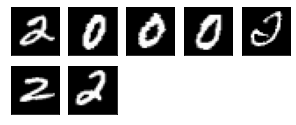




Cluster H:


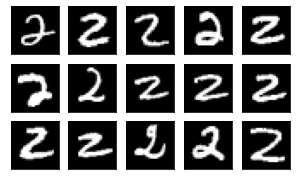




Cluster I:


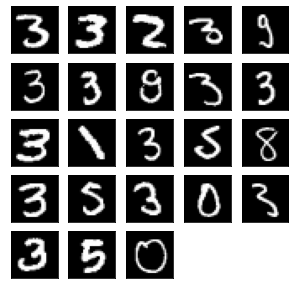




Cluster J:


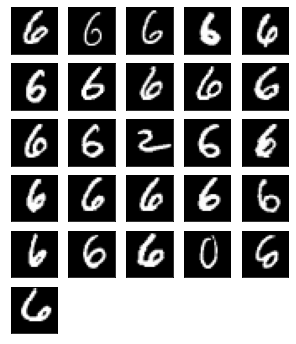

In [8]:
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import numpy as np
import string

# Helper function to display a digit
def showDigit(img, caption='', xlabel='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axes.get_xaxis().set_ticks([])
    subplot.axes.get_yaxis().set_ticks([])
    plt.title(caption)
    plt.xlabel(xlabel)
    subplot.imshow(imgr, cmap='gray')

def displayClusters(data):
    images = np.array(data.select("features").cache().take(250))
    clusters = data.select("closest_cluster").cache().take(250)

    for cluster in range(10):
        print('\n\n\nCluster {}:'.format(string.ascii_uppercase[cluster]))
        digits = [ img for l, img in zip(clusters, images) if int(l.closest_cluster) == cluster ]
        height=((len(digits)-1)//5)+1
        width=5
        plt.rcParams["figure.figsize"] = (width,height)
        _, subplots = plt.subplots(height, width)
        subplots=np.ndarray.flatten(subplots)
        for subplot, image in zip(subplots, digits):
            showDigit(image, subplot=subplot)
        for subplot in subplots[len(digits):]:
            subplot.axis('off')

        plt.show()

displayClusters(transformed_data)

# Endpoint re-use

We can connect the initial endpoint using its unique name. Make sure that no endpoint is created as we attach to the existing model (```endpointCreationPolicy```). ```KMeansProtobufResponseRowDeserializer``` is used so that the output of the endpoint on SageMaker will be deserialized in the right way and passed on back to Spark in a DataFrame with the correct columns.

In [11]:
from sagemaker_pyspark import SageMakerModel
from sagemaker_pyspark import EndpointCreationPolicy
from sagemaker_pyspark.transformation.serializers import ProtobufRequestRowSerializer
from sagemaker_pyspark.transformation.deserializers import KMeansProtobufResponseRowDeserializer

attachedModel = SageMakerModel(
    existingEndpointName = endpoint,
    endpointCreationPolicy = EndpointCreationPolicy.DO_NOT_CREATE,
    endpointInstanceType = None, # Required
    endpointInitialInstanceCount = None, # Required
    requestRowSerializer = ProtobufRequestRowSerializer(featuresColumnName = "features"), # Optional: already default value
    responseRowDeserializer = KMeansProtobufResponseRowDeserializer( # Optional: already default values
      distance_to_cluster_column_name = "distance_to_cluster",
      closest_cluster_column_name = "closest_cluster")
)

In [13]:
transformedData2 = attachedModel.transform(test_data)
transformedData2.show()

+-----+--------------------+-------------------+---------------+
|label|            features|distance_to_cluster|closest_cluster|
+-----+--------------------+-------------------+---------------+
|  5.0|(784,[152,153,154...| 1664.3218994140625|            4.0|
|  0.0|(784,[127,128,129...|  1423.726806640625|            2.0|
|  4.0|(784,[160,161,162...| 1691.2786865234375|            0.0|
|  1.0|(784,[158,159,160...|   1355.93408203125|            1.0|
|  9.0|(784,[208,209,210...| 1417.4210205078125|            5.0|
|  2.0|(784,[155,156,157...| 1652.2637939453125|            6.0|
|  1.0|(784,[124,125,126...| 1443.8995361328125|            1.0|
|  3.0|(784,[151,152,153...| 1601.7098388671875|            4.0|
|  1.0|(784,[152,153,154...|   1176.58935546875|            1.0|
|  4.0|(784,[134,135,161...|  1526.646240234375|            3.0|
|  3.0|(784,[123,124,125...|     1487.634765625|            4.0|
|  5.0|(784,[216,217,218...| 1530.1322021484375|            1.0|
|  3.0|(784,[143,144,145.

### Create model and endpoint from model data

A new SageMakerModel and endpoint are created referring directy to previous model data in the MNIST S3 bucket. Model data is specified using ```modelPath```, ```modelExecutionRoleARN```, and ```modelImage```, shown below.

In [21]:
from sagemaker_pyspark import S3DataPath

MODEL_S3_PATH = S3DataPath(kmeans_model.modelPath.bucket, kmeans_model.modelPath.objectPath)
MODEL_ROLE_ARN = kmeans_model.modelExecutionRoleARN
MODEL_IMAGE_PATH = kmeans_model.modelImage

print(MODEL_S3_PATH.bucket + MODEL_S3_PATH.objectPath)
#print(MODEL_ROLE_ARN) # Hidden just in case :)
print(MODEL_IMAGE_PATH)

336405771426-sagemaker-us-east-1754cc5ea-7951-4ae9-aade-5946a04f4afa/trainingJob-e8fda6d78b34-2021-03-21T21-59-17-413/trainingJob-e8fda6d78b34-2021-03-21T21-59-17-413/output/model.tar.gz
382416733822.dkr.ecr.us-east-1.amazonaws.com/kmeans:1


In [16]:
from sagemaker_pyspark import RandomNamePolicy

retrievedModel = SageMakerModel(
    modelPath = MODEL_S3_PATH,
    modelExecutionRoleARN = MODEL_ROLE_ARN,
    modelImage = MODEL_IMAGE_PATH,
    endpointInstanceType = "ml.t2.medium",
    endpointInitialInstanceCount = 1,
    requestRowSerializer = ProtobufRequestRowSerializer(),
    responseRowDeserializer = KMeansProtobufResponseRowDeserializer(),
    namePolicy = RandomNamePolicy("sparksm-1b-"),
    endpointCreationPolicy = EndpointCreationPolicy.CREATE_ON_TRANSFORM
)

In [20]:
transformedData3 = retrievedModel.transform(test_data)
transformedData3.show()

+-----+--------------------+-------------------+---------------+
|label|            features|distance_to_cluster|closest_cluster|
+-----+--------------------+-------------------+---------------+
|  5.0|(784,[152,153,154...| 1664.3218994140625|            4.0|
|  0.0|(784,[127,128,129...|  1423.726806640625|            2.0|
|  4.0|(784,[160,161,162...| 1691.2786865234375|            0.0|
|  1.0|(784,[158,159,160...|   1355.93408203125|            1.0|
|  9.0|(784,[208,209,210...| 1417.4210205078125|            5.0|
|  2.0|(784,[155,156,157...| 1652.2637939453125|            6.0|
|  1.0|(784,[124,125,126...| 1443.8995361328125|            1.0|
|  3.0|(784,[151,152,153...| 1601.7098388671875|            4.0|
|  1.0|(784,[152,153,154...|   1176.58935546875|            1.0|
|  4.0|(784,[134,135,161...|  1526.646240234375|            3.0|
|  3.0|(784,[123,124,125...|     1487.634765625|            4.0|
|  5.0|(784,[216,217,218...| 1530.1322021484375|            1.0|
|  3.0|(784,[143,144,145.

### Create model and endpoint from job training data

SageMakerModel and Endpoint created by referring to previously completed training job. We specify ```trainingJobName``` instead of specifying the data from S3. 

In [23]:
TRAINING_JOB_NAME = "trainingJob-e8fda6d78b34-2021-03-21T21-59-17-413"
MODEL_ROLE_ARN = kmeans_model.modelExecutionRoleARN
MODEL_IMAGE_PATH = kmeans_model.modelImage

In [24]:
modelFromJob = SageMakerModel.fromTrainingJob(
    trainingJobName = TRAINING_JOB_NAME,
    modelExecutionRoleARN = MODEL_ROLE_ARN,
    modelImage = MODEL_IMAGE_PATH,
    endpointInstanceType = "ml.t2.medium",
    endpointInitialInstanceCount = 1,
    requestRowSerializer = ProtobufRequestRowSerializer(),
    responseRowDeserializer = KMeansProtobufResponseRowDeserializer(),
    namePolicy = RandomNamePolicy("sparksm-1c-"),
    endpointCreationPolicy = EndpointCreationPolicy.CREATE_ON_TRANSFORM
)

In [25]:
transformedData4 = modelFromJob.transform(test_data)
transformedData4.show()

+-----+--------------------+-------------------+---------------+
|label|            features|distance_to_cluster|closest_cluster|
+-----+--------------------+-------------------+---------------+
|  5.0|(784,[152,153,154...| 1664.3218994140625|            4.0|
|  0.0|(784,[127,128,129...|  1423.726806640625|            2.0|
|  4.0|(784,[160,161,162...| 1691.2786865234375|            0.0|
|  1.0|(784,[158,159,160...|   1355.93408203125|            1.0|
|  9.0|(784,[208,209,210...| 1417.4210205078125|            5.0|
|  2.0|(784,[155,156,157...| 1652.2637939453125|            6.0|
|  1.0|(784,[124,125,126...| 1443.8995361328125|            1.0|
|  3.0|(784,[151,152,153...| 1601.7098388671875|            4.0|
|  1.0|(784,[152,153,154...|   1176.58935546875|            1.0|
|  4.0|(784,[134,135,161...|  1526.646240234375|            3.0|
|  3.0|(784,[123,124,125...|     1487.634765625|            4.0|
|  5.0|(784,[216,217,218...| 1530.1322021484375|            1.0|
|  3.0|(784,[143,144,145.

In [65]:
import pandas as pd
from pyspark.mllib.evaluation import MulticlassMetrics

predictionAndLabels = modelFromJob.transform(test_data).select('label', 'closest_cluster')
metrics = MulticlassMetrics(predictionAndLabels.rdd.map(lambda x: tuple(map(float, x))))

confusion_matrix = metrics.confusionMatrix().toArray()
labels = [int(l) for l in metrics.call('labels')]
confusion_matrix = pd.DataFrame(confusion_matrix , index=labels, columns=labels)

print("MNIST XGBoost Confusion Matrix")
confusion_matrix

Py4JJavaError: An error occurred while calling o418.confusionMatrix.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 22.0 failed 1 times, most recent failure: Lost task 0.0 in stage 22.0 (TID 50, localhost, executor driver): com.amazonaws.services.sagemakerruntime.model.ValidationErrorException: Endpoint sparksm-1c-endpoint-99ba27a24678-2021-03-21T22-45-35-796 of account 336405771426 not found. (Service: AmazonSageMakerRuntime; Status Code: 400; Error Code: ValidationError; Request ID: e3ef4afc-f46e-4022-bc0b-4a37854a7009; Proxy: null)
	at com.amazonaws.http.AmazonHttpClient$RequestExecutor.handleErrorResponse(AmazonHttpClient.java:1811)
	at com.amazonaws.http.AmazonHttpClient$RequestExecutor.handleServiceErrorResponse(AmazonHttpClient.java:1395)
	at com.amazonaws.http.AmazonHttpClient$RequestExecutor.executeOneRequest(AmazonHttpClient.java:1371)
	at com.amazonaws.http.AmazonHttpClient$RequestExecutor.executeHelper(AmazonHttpClient.java:1145)
	at com.amazonaws.http.AmazonHttpClient$RequestExecutor.doExecute(AmazonHttpClient.java:802)
	at com.amazonaws.http.AmazonHttpClient$RequestExecutor.executeWithTimer(AmazonHttpClient.java:770)
	at com.amazonaws.http.AmazonHttpClient$RequestExecutor.execute(AmazonHttpClient.java:744)
	at com.amazonaws.http.AmazonHttpClient$RequestExecutor.access$500(AmazonHttpClient.java:704)
	at com.amazonaws.http.AmazonHttpClient$RequestExecutionBuilderImpl.execute(AmazonHttpClient.java:686)
	at com.amazonaws.http.AmazonHttpClient.execute(AmazonHttpClient.java:550)
	at com.amazonaws.http.AmazonHttpClient.execute(AmazonHttpClient.java:530)
	at com.amazonaws.services.sagemakerruntime.AmazonSageMakerRuntimeClient.doInvoke(AmazonSageMakerRuntimeClient.java:294)
	at com.amazonaws.services.sagemakerruntime.AmazonSageMakerRuntimeClient.invoke(AmazonSageMakerRuntimeClient.java:261)
	at com.amazonaws.services.sagemakerruntime.AmazonSageMakerRuntimeClient.invoke(AmazonSageMakerRuntimeClient.java:250)
	at com.amazonaws.services.sagemakerruntime.AmazonSageMakerRuntimeClient.executeInvokeEndpoint(AmazonSageMakerRuntimeClient.java:216)
	at com.amazonaws.services.sagemakerruntime.AmazonSageMakerRuntimeClient.invokeEndpoint(AmazonSageMakerRuntimeClient.java:187)
	at com.amazonaws.services.sagemaker.sparksdk.transformation.util.RequestBatchIterator.hasNext(RequestBatchIterator.scala:133)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$12$$anon$1.hasNext(WholeStageCodegenExec.scala:631)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.hasNext(SerDeUtil.scala:153)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.foreach(SerDeUtil.scala:148)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:223)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:444)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread$$anonfun$run$1.apply(PythonRunner.scala:250)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1992)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:173)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1661)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1649)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1648)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1648)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1882)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1820)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:743)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:742)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:742)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.tpByClass$lzycompute(MulticlassMetrics.scala:48)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.tpByClass(MulticlassMetrics.scala:44)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labels$lzycompute(MulticlassMetrics.scala:223)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labels(MulticlassMetrics.scala:223)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusionMatrix(MulticlassMetrics.scala:68)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: com.amazonaws.services.sagemakerruntime.model.ValidationErrorException: Endpoint sparksm-1c-endpoint-99ba27a24678-2021-03-21T22-45-35-796 of account 336405771426 not found. (Service: AmazonSageMakerRuntime; Status Code: 400; Error Code: ValidationError; Request ID: e3ef4afc-f46e-4022-bc0b-4a37854a7009; Proxy: null)
	at com.amazonaws.http.AmazonHttpClient$RequestExecutor.handleErrorResponse(AmazonHttpClient.java:1811)
	at com.amazonaws.http.AmazonHttpClient$RequestExecutor.handleServiceErrorResponse(AmazonHttpClient.java:1395)
	at com.amazonaws.http.AmazonHttpClient$RequestExecutor.executeOneRequest(AmazonHttpClient.java:1371)
	at com.amazonaws.http.AmazonHttpClient$RequestExecutor.executeHelper(AmazonHttpClient.java:1145)
	at com.amazonaws.http.AmazonHttpClient$RequestExecutor.doExecute(AmazonHttpClient.java:802)
	at com.amazonaws.http.AmazonHttpClient$RequestExecutor.executeWithTimer(AmazonHttpClient.java:770)
	at com.amazonaws.http.AmazonHttpClient$RequestExecutor.execute(AmazonHttpClient.java:744)
	at com.amazonaws.http.AmazonHttpClient$RequestExecutor.access$500(AmazonHttpClient.java:704)
	at com.amazonaws.http.AmazonHttpClient$RequestExecutionBuilderImpl.execute(AmazonHttpClient.java:686)
	at com.amazonaws.http.AmazonHttpClient.execute(AmazonHttpClient.java:550)
	at com.amazonaws.http.AmazonHttpClient.execute(AmazonHttpClient.java:530)
	at com.amazonaws.services.sagemakerruntime.AmazonSageMakerRuntimeClient.doInvoke(AmazonSageMakerRuntimeClient.java:294)
	at com.amazonaws.services.sagemakerruntime.AmazonSageMakerRuntimeClient.invoke(AmazonSageMakerRuntimeClient.java:261)
	at com.amazonaws.services.sagemakerruntime.AmazonSageMakerRuntimeClient.invoke(AmazonSageMakerRuntimeClient.java:250)
	at com.amazonaws.services.sagemakerruntime.AmazonSageMakerRuntimeClient.executeInvokeEndpoint(AmazonSageMakerRuntimeClient.java:216)
	at com.amazonaws.services.sagemakerruntime.AmazonSageMakerRuntimeClient.invokeEndpoint(AmazonSageMakerRuntimeClient.java:187)
	at com.amazonaws.services.sagemaker.sparksdk.transformation.util.RequestBatchIterator.hasNext(RequestBatchIterator.scala:133)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$12$$anon$1.hasNext(WholeStageCodegenExec.scala:631)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.hasNext(SerDeUtil.scala:153)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.foreach(SerDeUtil.scala:148)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:223)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:444)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread$$anonfun$run$1.apply(PythonRunner.scala:250)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1992)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:173)


# XGBoost

In [28]:
from sagemaker_pyspark.algorithms import XGBoostSageMakerEstimator

# K-means estimator
xgboost_estimator = XGBoostSageMakerEstimator(
    trainingInstanceType="ml.m4.xlarge", # Instance type to train k-means on
    trainingInstanceCount=1,
    endpointInstanceType="ml.m4.xlarge", # Endpoint for model
    endpointInitialInstanceCount=1,
    sagemakerRole=IAMRole(iam_role))

# Set parameters
xgboost_estimator.setObjective('multi:softmax')
xgboost_estimator.setNumRound(25)
xgboost_estimator.setNumClasses(10)

# Fit on training data
xg_boost_model = xgboost_estimator.fit(training_data)

# Run predict / deserialization with transform
transformed_data = xg_boost_model.transform(test_data)
transformed_data.show()

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|  5.0|(784,[152,153,154...|       5.0|
|  0.0|(784,[127,128,129...|       0.0|
|  4.0|(784,[160,161,162...|       4.0|
|  1.0|(784,[158,159,160...|       1.0|
|  9.0|(784,[208,209,210...|       9.0|
|  2.0|(784,[155,156,157...|       2.0|
|  1.0|(784,[124,125,126...|       1.0|
|  3.0|(784,[151,152,153...|       3.0|
|  1.0|(784,[152,153,154...|       1.0|
|  4.0|(784,[134,135,161...|       4.0|
|  3.0|(784,[123,124,125...|       3.0|
|  5.0|(784,[216,217,218...|       5.0|
|  3.0|(784,[143,144,145...|       3.0|
|  6.0|(784,[72,73,74,99...|       6.0|
|  1.0|(784,[151,152,153...|       1.0|
|  7.0|(784,[211,212,213...|       7.0|
|  2.0|(784,[151,152,153...|       2.0|
|  8.0|(784,[159,160,161...|       8.0|
|  6.0|(784,[100,101,102...|       6.0|
|  9.0|(784,[209,210,211...|       9.0|
+-----+--------------------+----------+
only showing top 20 rows



In [36]:
# Metrics

predictionAndLabels = xg_boost_model.transform(test_data).select('label', 'prediction')
metrics = MulticlassMetrics(predictionAndLabels.rdd.map(lambda x: tuple(map(float, x))))

In [42]:
confusion_matrix = metrics.confusionMatrix().toArray()
labels = [int(l) for l in metrics.call('labels')]

In [43]:
confusion_matrix = pd.DataFrame(confusion_matrix , index=labels, columns=labels)

In [63]:
print("MNIST XGBoost Confusion Matrix")
confusion_matrix

MNIST XGBoost Confusion Matrix


,0,1,2,3,4,5,6,7,8,9
0,5919.0,0.0,2.0,0.0,0.0,1.0,2.0,0.0,1.0,6.0
1,0.0,6716.0,8.0,5.0,3.0,3.0,4.0,7.0,7.0,6.0
2,1.0,12.0,5904.0,22.0,1.0,1.0,0.0,9.0,10.0,0.0
3,0.0,4.0,5.0,6026.0,0.0,14.0,0.0,2.0,4.0,7.0
4,0.0,2.0,10.0,0.0,5777.0,3.0,4.0,10.0,3.0,32.0
5,0.0,0.0,0.0,19.0,0.0,5377.0,7.0,1.0,3.0,7.0
6,1.0,0.0,4.0,0.0,6.0,12.0,5897.0,0.0,7.0,0.0
7,0.0,6.0,15.0,26.0,3.0,0.0,0.0,6199.0,2.0,37.0
8,2.0,0.0,6.0,9.0,1.0,3.0,4.0,4.0,5797.0,9.0
9,0.0,2.0,4.0,24.0,51.0,7.0,0.0,33.0,17.0,5845.0


In [61]:
print(f'Accuracy: {metrics.accuracy}')
print(f'Recall: {metrics.recall()}')
print(f'Precision: {metrics.precision()}')
print(f'F1-Score: {metrics.fMeasure()}')

Accuracy: 0.99095
Recall: 0.99095
Precision: 0.99095
F1-Score: 0.99095


## Clean-up

Since we are not making anymore inferences, we can now delete the resources (endpoints, models, configs, etc).

In [64]:
# Delete the resources
from sagemaker_pyspark import SageMakerResourceCleanup

def cleanUp(model):
    resource_cleanup = SageMakerResourceCleanup(model.sagemakerClient)
    resource_cleanup.deleteResources(model.getCreatedResources())

# Don't forget to include any models or pipeline models that you created in the notebook
models = [kmeans_model, retrievedModel, modelFromJob, xgboost_estimator]

# Delete regular SageMakerModels
for m in models:
    cleanUp(m)

AttributeError: 'XGBoostSageMakerEstimator' object has no attribute 'getCreatedResources'